# Training a ML Model using the serenityff-charge package

## Import necessary packages and set file paths:

The [Trainer](../gnn/training/trainer.py) is a class that facilitates the training of an ML model and the [ChargeCorrectedNodeWiseAttentiveFP](../gnn/utils/model.py) is the model, that was trained in this work.

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

from shutil import rmtree
import pandas as pd
import torch
from rdkit import Chem

from serenityff.charge.gnn.training.trainer import Trainer, ChargeCorrectedNodeWiseAttentiveFP
from serenityff.charge.gnn.utils.model import TorsionWiseAttentiveFP


sdf_file = "../data/example.sdf"
pt_file = "../data/example_graphs.pt"
state_dict_path = "../data/example_state_dict.pt"
model_path = "../data/example_model.pt"

## Instantiate the trainer

Here you can specify whether you want to train your model on a CUDA enabled gpu or on the cpu, simply by setting `device = "cuda" / "cpu"`.

The loss function for the training is set to the `torch.nn.functional.mse_loss` by default. Provide any other callable for loss calculation with the kwarg `_loss_function_`.

In [2]:

import numpy as np
def cross_entropy_loss(x,y,num_buckets=100):
    y_bucket = torch.bucketize(y.unsqueeze(1), torch.tensor(np.arange(-1,1,2/num_buckets)))
    bin_tensor = torch.zeros(x.shape)
    bin_tensor.scatter_(1, y_bucket, 1)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(x, bin_tensor)
    return loss

In [3]:
y = torch.tensor([0.1,0.2,0.3,0.4,0.5,0.6])

torch.bucketize(y, torch.tensor(np.arange(-1,1,1/20)))

tensor([23, 25, 27, 29, 30, 33])

In [4]:
np.arange(-1,1,2/20)

array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01])

In [5]:
import numpy as np
np.arange(-0.5,0.5,1/20)

array([-5.00000000e-01, -4.50000000e-01, -4.00000000e-01, -3.50000000e-01,
       -3.00000000e-01, -2.50000000e-01, -2.00000000e-01, -1.50000000e-01,
       -1.00000000e-01, -5.00000000e-02, -1.11022302e-16,  5.00000000e-02,
        1.00000000e-01,  1.50000000e-01,  2.00000000e-01,  2.50000000e-01,
        3.00000000e-01,  3.50000000e-01,  4.00000000e-01,  4.50000000e-01])

In [6]:
trainer = Trainer(device = "cpu",loss_function=cross_entropy_loss)

## Initialize model, optimizer and setting output path

### Load existing model

You can load an already existing `ChargeCorrectedNodeWiseAttentiveFP` by loading a saved model or a saved state_dict from a previously trained model. 

This of course only works if the model or the state dict originate or are a `ChargeCorrectedNodeWiseAttentiveFP`.



In [7]:
#trainer.model = state_dict_path
#trainer.model = model_path

## Train new model

You can also train a new model.

Also, for the trainer to work, you have to provide it an optimizer, and a string to where trained model and loss files should be saved.

In [23]:
trainer.model = TorsionWiseAttentiveFP(hidden_channels=200,out_channels=20)
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr = 10**-5)
trainer.save_prefix = "./training/example"

### Generate molecular graph from .sdf files

There are two possibilities to load/generate molecular graphs. Either, you load in previously generated graphs by using `Trainer.load_graphs_from_pt()` or you generate them from an .sdf file containing molecules and their charges, that are used for the training. See [prep_sdf_input.ipynb](prep_sdf_input.ipynb) for the preparation of said sdf files.

In [24]:
#trainer.load_graphs_from_pt(pt_file=pt_file)
trainer.gen_torsion_grahs_from_sdf(sdf_file=sdf_file)
trainer.prepare_training_data(train_ratio=0.8)

In [25]:
from serenityff.charge.gnn.utils.rdkit_helper import get_list_of_torsion_indices_tuples, get_all_torsion_angles

In [26]:
supl = Chem.SDMolSupplier(sdf_file)

In [27]:
get_list_of_torsion_indices_tuples(supl[0])

[(1, 11, 10, 5),
 (11, 10, 5, 4),
 (10, 5, 4, 2),
 (5, 4, 2, 1),
 (4, 2, 1, 11),
 (2, 1, 11, 10),
 (6, 7, 8, 9),
 (7, 8, 9, 10),
 (8, 9, 10, 5),
 (9, 10, 5, 6),
 (10, 5, 6, 7),
 (5, 6, 7, 8)]

In [28]:
trainer._data[0].torch_indices

tensor([[ 1, 11, 10,  5],
        [11, 10,  5,  4],
        [10,  5,  4,  2],
        [ 5,  4,  2,  1],
        [ 4,  2,  1, 11],
        [ 2,  1, 11, 10],
        [ 6,  7,  8,  9],
        [ 7,  8,  9, 10],
        [ 8,  9, 10,  5],
        [ 9, 10,  5,  6],
        [10,  5,  6,  7],
        [ 5,  6,  7,  8]])

### Train a new model

To train a model, use the function `train_model()`. Specify epochs and batch size (defaults to 64).

This function saves you the train and eval losses in seperate files as well as the model's state dict after the training.

In [29]:
# if higher results is closer to suspected results in the end (still quite fast)
epochs = 100
train_loss, eval_loss = trainer.train_model(epochs=epochs,batch_size=32,verbose=True)

0.0319669246673584
Epoch: 0/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.03333449363708496
Epoch: 1/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.03149247169494629
Epoch: 2/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.032007455825805664
Epoch: 3/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.03914165496826172
Epoch: 4/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.03871417045593262
Epoch: 5/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.04053378105163574
Epoch: 6/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.03921794891357422
Epoch: 7/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.036138296127319336
Epoch: 8/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.030215024948120117
Epoch: 9/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.030551910400390625
Epoch: 10/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.03153371810913086
Epoch: 11/100 - Train Loss: 3.00E+00 - Eval Loss: 3.00E+00
0.03087759017944336
Epoch: 12/100 - Train Loss: 3.00E+00 - 

## Predict charges for test molecule

To predict values for known or unknown molecules, use the `predict()` function. It takes either rdkit molecules or molecular graphs (or Sequences of them) created as shown above as input. 

In [17]:
from rdkit.Chem import AllChem

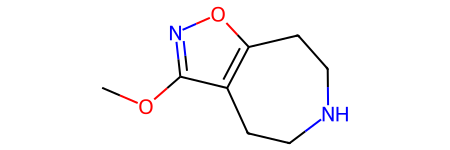

In [18]:
supl[2]

In [19]:
mol = Chem.MolFromSmiles('CCCC')
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
trainer.predict(mol)

[[[7.749866829005747e-13,
   1.0732630062459947e-12,
   6.917387669613806e-12,
   1.2050070143099223e-12,
   1.971685835433501e-11,
   1.432717000593442e-10,
   6.148654502213802e-11,
   4.0385225719141715e-10,
   5.993097592629434e-14,
   1.062047178717121e-15,
   0.5,
   0.5,
   4.0865596497019485e-12,
   3.1493144494288772e-15,
   2.199708817873791e-11,
   3.707487008369759e-12,
   5.70798833546271e-13,
   1.8682104474532224e-12,
   5.478702344227648e-13,
   1.0457412713549274e-11]]]

In [20]:
tors = []
for m in range(1000):
    mol = Chem.MolFromSmiles('CCCC')
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    tors.append(get_all_torsion_angles(mol)[0][1])

In [21]:
21 bins

SyntaxError: invalid syntax (2383429017.py, line 1)

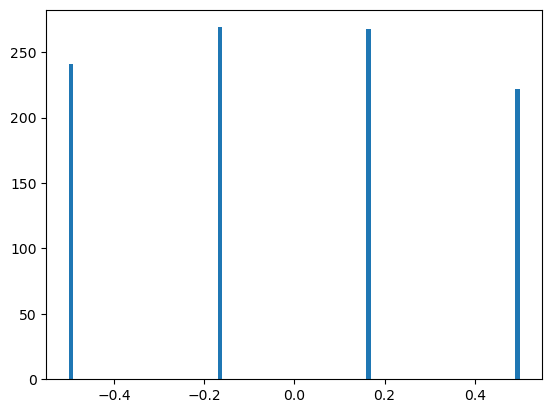

In [22]:
import matplotlib.pyplot as plt
_ = plt.hist(tors, bins=100)

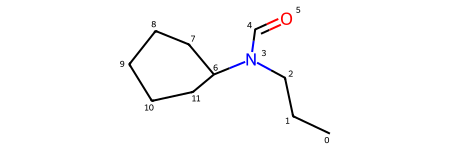

In [72]:
# show rdkit mol with atom indices
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices = True
supl[8]

Remove all the generated files by this cool example notebook.

In [10]:
rmtree("./training/")